# 새로 만든 데이터 로드해서 시작하기 아래는 초기 코드

# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import os
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib as mpl
import gc
plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
os.getcwd()

'D:\\kaggle\\ELO'

# 2. 데이터 로드
* train.csv: 학습 데이터
* test.csv: 테스트 데이터

* sample_submission.csv: 제출 예시 데이터

* historical_transactions.csv: 상인 거래 데이터(3개월)
* new_merchant_transactions.csv: 상인 거래 데이터(2개월) 

* merchants.csv: 상인관련 지표 데이터

* Data_Dictionary.xlsx: 데이터 설명 엑셀

In [2]:
%%time
train=pd.read_csv("D:/kaggle/ELO/data/train.csv",encoding='utf-8')
test=pd.read_csv("D:/kaggle/ELO/data/test.csv",encoding='utf-8')

trans_hist=pd.read_csv("D:/kaggle/ELO/data/historical_transactions.csv",encoding='utf-8')
trans_new=pd.read_csv("D:/kaggle/ELO/data/new_merchant_transactions.csv",encoding='utf-8')

merchant=pd.read_csv("D:/kaggle/ELO/data/merchants.csv",encoding='utf-8')

sample_sub=pd.read_csv("D:/kaggle/ELO/data/sample_submission.csv",encoding='utf-8')

Wall time: 1min 4s


In [3]:
train_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'train')
his_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'history')
new_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'new_merchant_period')
merchant_dic=pd.read_excel("D:/kaggle/ELO/data/Data_Dictionary.xlsx",sheet_name = 'merchant')

# 3. 데이터 형태 및 card_id 포함관계 확인

In [ ]:
print("------------전체 데이터 행/열 개수 확인------------")
print("train         : {} ".format(train.shape))
print("test          : {} ".format(test.shape))
print("trans_hist    : {} ".format(trans_hist.shape))
print("trans_new     : {} ".format(trans_new.shape))
print("-----------------------------------------")

In [ ]:
############################ Set(집합) 다루기 ############################ 
##  1. 합집합 (|)
##  2. 차집합 (-)
##  3. 교집합 (&)
##########################################################################

In [ ]:
### unique card_id
train_id=set(np.unique(train.card_id))
test_id=set(np.unique(test.card_id))
trans_hist_id=set(np.unique(trans_hist.card_id))
trans_new_id=set(np.unique(trans_new.card_id))
traintest_id=train_id|test_id 
print("------------ unique card_id 개수 확인------------")
print("train_id           : {} 개".format(len(train_id)))
print("test_id            : {} 개".format(len(test_id)))
print("train+test         : {} 개".format(len(traintest_id)))
print()
print("trans_hist_id      : {} 개".format(len(trans_hist_id)))
print("trans_new_id       : {} 개".format(len(trans_new_id)))
print("-------------------------------------------------")

In [ ]:
### intersect card_id
print("------------ card_id 포함 관계 확인------------")
print("# 중복(포함)없음 - 배반관계")
print("train         ∩   test          : {} 개".format(len(train_id&test_id)))              # 중복 없음
print()
print("### train+test  ⊂   trans_hist ###")
print("train         ∩   trans_hist : {} 개".format(len(train_id&trans_hist_id)))     # train      ⊂ trans_hist 
print("test          ∩   trans_hist : {} 개".format(len(test_id&trans_hist_id)))      # test       ⊂ trans_hist 
print("train+test    ∩   trans_hist : {} 개".format(len(traintest_id&trans_hist_id))) # train+test ⊂trans_hist 
print() 

print("### train+test  ⊂   trans_new ###")
print("train         ∩   trans_new     : {} 개".format(len(train_id&trans_new_id)))         # train      ⊂ trans_new 
print("test          ∩   trans_new     : {} 개".format(len(test_id&trans_new_id)))          # test       ⊂ trans_new 
print("train+test    ∩   trans_new     : {} 개".format(len(traintest_id&trans_new_id)))     # train+test ⊂ trans_new 
print()

print("### trans_new   ⊂ trans_hist ###")
print("trans_hist ∩ trans_new       : {} 개".format(len(trans_hist_id&trans_new_id))) # trans_new  ⊂ trans_hist
print("------------------------------------------------")

# 4. base_model 생성을 위한 데이터 병합
* data_df  : train+test
* trans_df : history+new
* df       : trans_df 에 train, test 데이터 조인한거(left join , by 'card_id)   
* train_df : df 에서 train 데이터만 뺀거
* test_df  : df 에서 test 데이터만 뺀거

In [4]:
### data_df : train + test only 
test['target']=np.nan
data_df = pd.concat([train,test]).reset_index(drop=True)
data_df.tail(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
325537,2016-09,C_ID_21d56d950c,5,1,1,NaN
325538,2017-06,C_ID_6c46fc5a9d,2,1,0,NaN
325539,2016-10,C_ID_87e7979a5f,5,1,1,NaN


In [5]:
### trans_df : history+ new
trans_df = pd.concat([trans_hist,trans_new]).reset_index(drop=True)
trans_df.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1.0,9,37


In [6]:
### df : trans_df 에 train,test 데이터 조인한거(left join, by 'card_id')
df=pd.merge(trans_df,data_df,on=['card_id'],how='left')
df.category_2.fillna(999,inplace=True)
df['category_2']=df['category_2'].astype('int')
df.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1,9,37,2017-09,4,3,0,0.360656
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3,7,16,2016-07,2,2,0,-1.680951
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1,9,37,2017-04,2,2,0,4.568632


In [7]:
### train_df, test_df : df에서 train/test 분리한거
train_df=df.loc[df.card_id.isin(train.card_id)].reset_index(drop=True)
test_df=df.loc[df.card_id.isin(test.card_id)].reset_index(drop=True)

In [8]:
train_df.tail(3)
#train_df.info()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
19249691,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1,9,37,2017-09,4,3,0,0.360656
19249692,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3,7,16,2016-07,2,2,0,-1.680951
19249693,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1,9,37,2017-04,2,2,0,4.568632


In [9]:
test_df.tail(3)
#test.df.info()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
11825695,Y,C_ID_c07707ff74,194,N,2,C,87,M_ID_7dabac675c,1,-0.476431,2018-03-29 17:41:22,5,21,27,2015-09,5,1,1,NaN
11825696,Y,C_ID_611d4d588f,302,N,1,B,307,M_ID_ee5a6f6a35,2,-0.731881,2018-03-11 15:07:49,3,7,19,2017-10,2,2,0,NaN
11825697,Y,C_ID_1320dee851,142,N,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3,19,21,2017-08,3,1,1,NaN


# transaction에 합쳐진 train_df, test_df 타입 최적화 후 저장
* 차후 작업은 처리된 파일을 이용

In [10]:
def reduce_mem_usage(props, fillna=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [11]:
train, _ = reduce_mem_usage(train,fillna=False)
test, _ = reduce_mem_usage(test,fillna=False)
train_df, _ = reduce_mem_usage(train_df,fillna=False)
test_df, _ = reduce_mem_usage(test_df,fillna=False)

Memory usage of properties dataframe is : 9.243148803710938  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_3
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  target
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.429072380065918  MB
This is  47.91735450897139 % of the initial size
Memory usage of properties dataframe is : 5.6591339111328125  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
************

In [12]:
train.to_csv("D:/kaggle/ELO/data/new/train.csv",encoding='utf-8',index=None)
test.to_csv("D:/kaggle/ELO/data/new/test.csv",encoding='utf-8',index=None)
train_df.to_csv("D:/kaggle/ELO/data/new/train_df.csv",encoding='utf-8',index=None)
test_df.to_csv("D:/kaggle/ELO/data/new/test_df.csv",encoding='utf-8',index=None)

# 5. 타입 최적화된 데이터로 새로 시작

### 지난 번에 해보기로 했던거 확인
* target -30인 데이터 빼고 각 충성도 ~ 변수별 보기 : 별 차이 안남 그래도 대부분 - 값으로 나타남
* interval(purchase_date - first_active_month)을 month 기준 vs year 기준 설정: 일단 month로... year는 
* base model 생성을 위한 이상치 처리 및 특이치 확인 후 사용 여부 결정 : 밑에 정리

In [18]:
import pandas as pd
import numpy as np
import re
import os
import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import matplotlib as mpl
import gc
plt.rcParams['font.family'] = 'Malgun Gothic'
rc={'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 12.0, 'axes.titlesize': 20}
plt.rcParams.update(**rc)
mpl.rcParams['axes.unicode_minus'] = False
os.getcwd()

'C:\\Users\\meng'

In [19]:
%%time
train=pd.read_csv("D:/kaggle/ELO/data/new/train.csv",encoding='utf-8')
test=pd.read_csv("D:/kaggle/ELO/data/new/test.csv",encoding='utf-8')
train_df=pd.read_csv("D:/kaggle/ELO/data/new/train_df.csv",encoding='utf-8')
test_df=pd.read_csv("D:/kaggle/ELO/data/new/test_df.csv",encoding='utf-8')

Wall time: 1min 9s


In [20]:
def reduce_mem_usage(props, fillna=False):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('[*]skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [21]:
train, _ = reduce_mem_usage(train,fillna=False)
test, _ = reduce_mem_usage(test,fillna=False)
train_df, _ = reduce_mem_usage(train_df,fillna=False)
test_df, _ = reduce_mem_usage(test_df,fillna=False)

Memory usage of properties dataframe is : 9.24310302734375  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_3
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  target
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.4290266036987305  MB
This is  47.917096570236204 % of the initial size
Memory usage of properties dataframe is : 4.715919494628906  MB
******************************
Column:  feature_1
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  feature_2
dtype before:  int64
dtype after:  uint8
******************************
************

# 6. history + train = train_df  이상치 설정하고 모델 데이터 만들기

## 설정 기준 
* card_id : x 는 1:1로 통일(모델학습에서 필수)
* 이산형 데이터 -> 빈도수가 높은 value로 대체
* 연속형 데이터 -> mean,median 등의 통계량으로 대체

In [22]:
#train_df.tail(1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19249694 entries, 0 to 19249693
Data columns (total 19 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           object
category_2              uint16
state_id                int8
subsector_id            int8
first_active_month      object
feature_1               uint8
feature_2               uint8
feature_3               uint8
target                  float32
dtypes: float32(2), int16(3), int8(3), object(7), uint16(1), uint8(3)
memory usage: 1.4+ GB


In [23]:
#test_df.tail(1)
#test_df.info()

# flag_column
* card_id

In [24]:
train_test=set(train.card_id)|set(test.card_id)
train_test_transaction=set(train_df.card_id)|set(test_df.card_id)

print('------------------------ card_id 포함관계 확인 ------------------------')
print('card_id (train                                       ) : {} 개'.format(len(set(train.card_id))))
print('card_id (test                                        ) : {} 개'.format(len(set(test.card_id))))
print()
print('card_id (train             +  test                   ) : {} 개'.format(len(set(set(train.card_id)|set(test.card_id)))))
print('card_id (train_transaction +  test_transaction       ) : {} 개'.format(len(set(set(train_df.card_id)|set(test_df.card_id)))))
print()
print('card_id (train+test        ∩ train+test(transaction)) : {} 개'.format(len(train_test&train_test_transaction)))
print('-----------------------------------------------------------------------')

------------------------ card_id 포함관계 확인 ------------------------
card_id (train                                       ) : 201917 개
card_id (test                                        ) : 123623 개

card_id (train             +  test                   ) : 325540 개
card_id (train_transaction +  test_transaction       ) : 325540 개

card_id (train+test        ∩ train+test(transaction)) : 325540 개
-----------------------------------------------------------------------


# datetime_columns
* purchase_date
* first_active_month(train.csv)

### month_diff : purchase_date - first_active_year(month 기준) 데이터 추가
* month_diff가 -인 데이터는 논리상 모순인 데이터들
* 첫 구매일보다 일반 구매일이 더 이전 기간인 데이터 존재, 확인해보니 이 데이터 빼도 unique_id 개수 동일
* discussion에서도 확인하고 제거한 사람들이 보임... 근데 그냥 살리고 돌려도 RMSE 차이 별로 없다고 함

In [25]:
train_df['purchase_date_dt']=train_df['purchase_date'].apply(lambda x : x[0:7])
train_df['purchase_date_dt']=pd.to_datetime(train_df['purchase_date_dt'],format='%Y-%m')
train_df['first_active_month_dt']=pd.to_datetime(train_df['first_active_month'])
train_df['day_diff']=train_df['purchase_date_dt'] - train_df['first_active_month_dt']
train_df['month_diff']=train_df['day_diff'].apply(lambda x: str(x)[:-14]).astype('int')//30
                                                                                           
                                        
#train_df['purchase_year'] = train_df['purchase_date'].dt.year
#train_df['first_active_year'] = train_df['first_active_month'].dt.year
#train_df['year'] = train_df['purchase_date'].dt.month

In [26]:
train_df.loc[train_df.month_diff<0,['card_id','purchase_date','purchase_date_dt','first_active_month_dt','day_diff','month_diff']]

,card_id,purchase_date,purchase_date_dt,first_active_month_dt,day_diff,month_diff
186,C_ID_0e171c1b48,2017-02-25 09:38:46,2017-02-01,2017-03-01,-28 days,-1
199,C_ID_0e171c1b48,2017-02-25 09:46:33,2017-02-01,2017-03-01,-28 days,-1
215,C_ID_0e171c1b48,2017-02-25 09:40:21,2017-02-01,2017-03-01,-28 days,-1
376,C_ID_0e171c1b48,2017-02-25 09:51:40,2017-02-01,2017-03-01,-28 days,-1
20533,C_ID_bbde7637a1,2017-07-12 12:01:51,2017-07-01,2017-08-01,-31 days,-2
20541,C_ID_bbde7637a1,2017-07-06 12:11:05,2017-07-01,2017-08-01,-31 days,-2
20549,C_ID_bbde7637a1,2017-07-12 12:01:21,2017-07-01,2017-08-01,-31 days,-2
35515,C_ID_12898d9f0c,2017-09-22 12:47:05,2017-09-01,2017-10-01,-30 days,-1
38716,C_ID_a7d3313624,2017-01-06 15:05:26,2017-01-01,2017-04-01,-90 days,-3
56340,C_ID_d0a8c728be,2017-07-28 15:00:05,2017-07-01,2017-08-01,-31 days,-2


In [27]:
train_df.drop(columns=['purchase_date_dt','first_active_month_dt','day_diff'],inplace=True)

In [28]:
# 모순 데이터( purchase_date가 first_active_month 보다 빠른 데이터 ) 행 제거
train_df=train_df.loc[train_df.month_diff>=0,:]

In [29]:
train_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff
0,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3,11,37,2017-01,5,1,1,-2.352713,8
1,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1,15,19,2017-01,5,1,1,-2.352713,7
2,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1,15,33,2017-01,5,1,1,-2.352713,1
3,Y,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1,16,19,2017-01,5,1,1,-2.352713,7
4,Y,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3,17,33,2017-01,5,1,1,-2.352713,1


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19237031 entries, 0 to 19249693
Data columns (total 20 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           object
category_2              uint16
state_id                int8
subsector_id            int8
first_active_month      object
feature_1               uint8
feature_2               uint8
feature_3               uint8
target                  float32
month_diff              int32
dtypes: float32(2), int16(3), int32(1), int8(3), object(7), uint16(1), uint8(3)
memory usage: 1.6+ GB


In [31]:
train_df.isna().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3              145179
merchant_category_id         0
merchant_id             102268
month_lag                    0
purchase_amount              0
purchase_date                0
category_2                   0
state_id                     0
subsector_id                 0
first_active_month           0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
month_diff                   0
dtype: int64

### train_df 카운팅을 위해 임시열 cnt=1 생성

In [32]:
train_df['cnt']=1

# category_columns
* authorized_flag
* city_id
* category_1,2,3
* merchant_category_id
* merchant_id
* state_id
* subsector_id 

* feature_1,2,3(train.csv)

### 1. authorized_flag
* N/Y 으로 구성 → 0,1로 전환
* card_id 1:1 설정 기준은 card_id groupby시 가장 많이 나온 value

In [33]:
train_df.authorized_flag.value_counts()

Y    17687174
N     1549857
Name: authorized_flag, dtype: int64

In [34]:
train_df.authorized_flag=train_df.authorized_flag.apply(lambda x : 0 if x =="N" else 1 )

In [35]:
train_df.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
19249691,1,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,...,1,9,37,2017-09,4,3,0,0.360656,6,1
19249692,1,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,...,3,7,16,2016-07,2,2,0,-1.680951,20,1
19249693,1,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,...,1,9,37,2017-04,2,2,0,4.568633,12,1


In [36]:
train_df.loc[:,['card_id','authorized_flag','cnt']].groupby(['card_id','authorized_flag']).count()

cnt
card_id         authorized_flag     
C_ID_00007093c1 0                 35
                1                116
C_ID_0001506ef0 0                  4
                1                 64
C_ID_000183fdda 0                  1
                1                148
C_ID_00027503e2 0                 18
                1                 24
C_ID_0002c7c2c1 0                  9
                1                 64
C_ID_0003be3c83 0                 25
                1                152
C_ID_00042d509c 0                 44
                1                 20
C_ID_0004888ddd 0                  5
                1                 38
C_ID_0004b68c49 1                  7
C_ID_0004c2a5ab 0                  3
                1                 72
C_ID_0005b2f279 1                 16
C_ID_0005b5804f 1                  8
C_ID_0005f16cc8 0                 17
                1                139
C_ID_0006152db8 0                 10
                1                 78
C_ID_000616f4a8 0                  2
                1                 41
C_ID_000664aa02 1                 43
C_ID_00079fec55 0                  9
                1                 42
...                              ...
C_ID_fffd1207a8 1                776
C_ID_fffd24dcf3 0                  1
                1                 22
C_ID_fffd351e7f 0                 21
                1                240
C_ID_fffd93c8bf 0                  7
                1                140
C_ID_fffdad8aa0 0                  7
                1                132
C_ID_fffde15ab6 0                 10
                1                 73
C_ID_fffdf34798 1                 62
C_ID_fffe29a04a 0                  3
                1                 88
C_ID_fffe78b232 0                 11
                1                351
C_ID_fffe866457 0                  3
                1                 63
C_ID_fffea6de74 0                  8
                1                407
C_ID_fffeced303 0                 22
                1                168
C_ID_fffeed3a89 0                  3
                1                216
C_ID_ffff579d3a 0                 15
                1                100
C_ID_ffff828181 0                 24
                1                174
C_ID_fffffd5772 0                  9
                1                 78

[372232 rows x 1 columns]

### 2. city_id
* 1~347까지의 숫자 구성
* 346값이 유일하게 비어있으며, -1값이 있는 것으로 보아 -> -1이 346번이었지 않을까 추정됨, 346으로 바꿀까 고민...
* card_id 1:1 설정 기준은 가장 많이 나온 value

In [37]:
np.unique(train_df.city_id)

array([ -1,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,
        29,  30,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,  44,
        46,  47,  48,  49,  51,  52,  53,  54,  56,  57,  58,  60,  61,
        62,  63,  64,  65,  66,  68,  69,  70,  71,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  94,  96,  97,  98, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 131, 133, 135,
       136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194,
       195, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 20

In [38]:
train_df.city_id.value_counts()

 69     3202708
-1      1586335
 19      755855
 158     739137
 17      630066
 331     471328
 143     442357
 88      431756
 137     396042
 333     362355
 87      304459
 212     273615
 57      251171
 233     236172
 25      235527
 149     235369
 160     215652
 117     212892
 277     168176
 213     165428
 286     155201
 76      143887
 107     139274
 4       137263
 291     135955
 20      135302
 53      135082
 140     131723
 344     116674
 161     112416
         ...   
 118       5609
 84        5592
 112       5439
 54        5204
 326       5113
 222       4977
 254       4818
 71        4783
 235       4780
 327       4628
 227       4465
 306       4313
 221       4255
 293       4250
 122       4159
 204       4082
 205       4074
 130       4001
 237       3756
 215       2839
 89        2817
 207       2747
 263       2734
 178       2712
 315       2192
 319       1187
 92         618
 273        430
 316         96
 185         41
Name: city_id, Length: 3

### 3. category_1
* N/Y로 구성 -> 0/1로 변환
* card_id 1:1 설정 기준은 가장 많이 나온 value 

In [39]:
np.unique(train_df.category_1)

array(['N', 'Y'], dtype=object)

In [40]:
train_df.category_1=train_df.category_1.apply(lambda x: 0 if x=='N' else 1)
train_df.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
0,0,C_ID_5037ff576e,322,0,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,...,3,11,37,2017-01,5,1,1,-2.352713,8,1
1,1,C_ID_5037ff576e,138,0,1,B,307,M_ID_fe69229f24,-4,1.189469,...,1,15,19,2017-01,5,1,1,-2.352713,7,1


In [41]:
train_df.category_1.value_counts()

0    17913380
1     1323651
Name: category_1, dtype: int64

### 4. category_2
* 숫자형 카테고리, NA -> 999로 이전에 처리함
* card_id 1:1 설정 기준은 가장 많이 나온 value  

In [42]:
np.unique(train_df.category_2)

array([  1,   2,   3,   4,   5, 999], dtype=uint16)

In [43]:
train_df.category_2.value_counts()

1      10072993
3       2603795
5       2453939
4       1727789
999     1702623
2        675892
Name: category_2, dtype: int64

### 5. category_3
* 숫자형 카테고리, 결측치 존재 NA -> "Z"로 처리
* card_id 1:1 설정 기준은 가장 많이 나온 value  

In [44]:
train_df.category_3=train_df.category_3.fillna("Z")

In [45]:
np.unique(train_df.category_3)

array(['A', 'B', 'C', 'Z'], dtype=object)

In [46]:
train_df.category_3.value_counts()

A    10119416
B     7737094
C     1235342
Z      145179
Name: category_3, dtype: int64

### 6. merchant_category_id
* 불연속적인 숫자로 구성되어 있음 
* -1은 결측치로 추정 다른 값으로 대체 999
* card_id 1:1 설정 기준은 가장 많이 나온 value

In [47]:
np.unique(train_df.merchant_category_id)

array([ -1,   2,   9,  11,  14,  16,  18,  19,  21,  27,  31,  33,  34,
        36,  37,  38,  40,  45,  49,  52,  53,  56,  57,  59,  60,  63,
        67,  68,  69,  71,  78,  80,  81,  83,  86,  87,  90, 101, 105,
       108, 109, 110, 111, 114, 115, 117, 119, 126, 130, 131, 140, 141,
       145, 153, 154, 157, 162, 164, 166, 171, 172, 178, 179, 180, 181,
       182, 183, 184, 187, 190, 192, 195, 198, 201, 206, 209, 210, 215,
       216, 217, 222, 223, 224, 225, 226, 241, 245, 246, 247, 248, 249,
       259, 260, 261, 265, 266, 267, 268, 273, 274, 276, 278, 289, 290,
       292, 298, 299, 302, 307, 309, 311, 312, 315, 317, 319, 320, 330,
       332, 333, 334, 340, 342, 343, 345, 348, 351, 355, 356, 357, 358,
       360, 363, 367, 369, 373, 374, 381, 383, 384, 385, 386, 387, 391,
       393, 396, 398, 400, 401, 409, 411, 412, 414, 415, 416, 417, 419,
       420, 421, 422, 427, 430, 432, 434, 436, 437, 438, 443, 448, 451,
       454, 456, 457, 458, 462, 464, 469, 471, 472, 474, 478, 48

In [48]:
train_df.merchant_category_id=train_df.merchant_category_id.apply(lambda x: 999 if x==-1 else x)
train_df.loc[train_df.merchant_category_id==999]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
13689,1,C_ID_9861d0fa05,-1,1,1,B,999,M_ID_49d4a8510e,-11,2.253887,...,999,-1,-1,2016-10,1,3,0,-0.282730,4,1
28202,1,C_ID_28fa6e1b95,-1,1,12,C,999,M_ID_49d4a8510e,-11,2.713938,...,999,-1,-1,2016-04,3,3,1,-0.817255,11,1
38904,1,C_ID_deda0cca28,-1,1,1,B,999,M_ID_49d4a8510e,-5,-0.673278,...,999,-1,-1,2017-01,1,3,0,0.473914,8,1
56105,1,C_ID_99c391a674,-1,1,3,C,999,M_ID_49d4a8510e,-4,-0.451817,...,999,-1,-1,2016-10,4,2,0,-1.005359,12,1
67311,1,C_ID_b7cb3398bb,-1,1,1,B,999,M_ID_49d4a8510e,-5,-0.131527,...,999,-1,-1,2017-07,1,1,0,-3.129317,2,1
86252,0,C_ID_cbad782b86,-1,1,12,C,999,M_ID_49d4a8510e,-5,0.454732,...,999,-1,-1,2017-08,5,1,1,0.658205,1,1
86286,1,C_ID_cbad782b86,-1,1,12,C,999,M_ID_49d4a8510e,-6,0.454732,...,999,-1,-1,2017-08,5,1,1,0.658205,0,1
157136,1,C_ID_159c8cb0c6,-1,1,5,C,999,M_ID_49d4a8510e,-5,-0.298892,...,999,-1,-1,2017-05,2,1,0,-3.100943,4,1
157142,1,C_ID_159c8cb0c6,-1,1,3,C,999,M_ID_49d4a8510e,-8,-0.644352,...,999,-1,-1,2017-05,2,1,0,-3.100943,1,1
255575,1,C_ID_490ca3a578,-1,1,9,C,999,M_ID_49d4a8510e,-11,3.475782,...,999,-1,-1,2016-11,1,3,0,-0.997730,3,1


# 지역적 영향을 받는 변수들(city_id,state_id,subsector_id,merchant_category_id)의 경우
# -1값은 지역을 알 수 없어서 결측된 값으로 보임

### 7. merchant_id
* 자체 ID 성향이 짙으므로 사용 X

### 8. state_id
* 연속적인 숫자로 구성되어 있음 
* -1은 결측치로 추정 다른 값으로 대체 999
* card_id 1:1 설정 기준은 가장 많이 나온 value

In [49]:
np.unique(train_df.state_id)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int8)

In [50]:
train_df.state_id=train_df.state_id.apply(lambda x: 999 if x==-1 else x)
train_df.loc[train_df.state_id==999]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
18,1,C_ID_5037ff576e,-1,0,1,B,307,M_ID_d8281a0ff9,-11,-0.303581,...,999,999,19,2017-01,5,1,1,-2.352713,0,1
25,1,C_ID_5037ff576e,-1,0,1,B,307,M_ID_949996e6b5,0,-0.671775,...,999,999,19,2017-01,5,1,1,-2.352713,11,1
30,1,C_ID_5037ff576e,-1,0,1,B,307,M_ID_fe69229f24,-1,0.189755,...,999,999,19,2017-01,5,1,1,-2.352713,10,1
52,1,C_ID_5037ff576e,331,0,1,B,307,M_ID_1cf20d1419,0,0.244541,...,999,999,19,2017-01,5,1,1,-2.352713,11,1
71,1,C_ID_5037ff576e,-1,0,1,B,307,M_ID_9b26897b07,-1,0.575425,...,999,999,19,2017-01,5,1,1,-2.352713,10,1
79,1,C_ID_5037ff576e,-1,0,1,B,307,M_ID_fe69229f24,0,-0.671775,...,999,999,19,2017-01,5,1,1,-2.352713,11,1
87,1,C_ID_5037ff576e,-1,0,1,B,45,M_ID_6e67395fa3,0,-0.467415,...,999,999,18,2017-01,5,1,1,-2.352713,11,1
113,1,C_ID_5037ff576e,331,0,1,B,45,M_ID_54944a940b,0,-0.416325,...,999,999,18,2017-01,5,1,1,-2.352713,11,1
424,1,C_ID_fc8e41b9cf,170,0,1,B,307,M_ID_2e0430b435,-7,-0.626696,...,999,999,19,2017-07,4,3,0,-0.158283,0,1
459,1,C_ID_fc8e41b9cf,170,0,1,B,367,M_ID_37f7529614,0,-0.665765,...,999,999,16,2017-07,4,3,0,-0.158283,7,1


### 9. subsector_id 
* 연속적인 숫자로 구성되어 있음 
* -1은 결측치로 추정 다른 값으로 대체 999
* card_id 1:1 설정 기준은 가장 많이 나온 value

In [51]:
np.unique(train_df.subsector_id)

array([-1,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41], dtype=int8)

In [52]:
train_df.subsector_id=train_df.subsector_id.apply(lambda x: 999 if x==-1 else x)
train_df.loc[train_df.subsector_id==999]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
13689,1,C_ID_9861d0fa05,-1,1,1,B,999,M_ID_49d4a8510e,-11,2.253887,...,999,999,999,2016-10,1,3,0,-0.282730,4,1
28202,1,C_ID_28fa6e1b95,-1,1,12,C,999,M_ID_49d4a8510e,-11,2.713938,...,999,999,999,2016-04,3,3,1,-0.817255,11,1
38904,1,C_ID_deda0cca28,-1,1,1,B,999,M_ID_49d4a8510e,-5,-0.673278,...,999,999,999,2017-01,1,3,0,0.473914,8,1
56105,1,C_ID_99c391a674,-1,1,3,C,999,M_ID_49d4a8510e,-4,-0.451817,...,999,999,999,2016-10,4,2,0,-1.005359,12,1
67311,1,C_ID_b7cb3398bb,-1,1,1,B,999,M_ID_49d4a8510e,-5,-0.131527,...,999,999,999,2017-07,1,1,0,-3.129317,2,1
86252,0,C_ID_cbad782b86,-1,1,12,C,999,M_ID_49d4a8510e,-5,0.454732,...,999,999,999,2017-08,5,1,1,0.658205,1,1
86286,1,C_ID_cbad782b86,-1,1,12,C,999,M_ID_49d4a8510e,-6,0.454732,...,999,999,999,2017-08,5,1,1,0.658205,0,1
157136,1,C_ID_159c8cb0c6,-1,1,5,C,999,M_ID_49d4a8510e,-5,-0.298892,...,999,999,999,2017-05,2,1,0,-3.100943,4,1
157142,1,C_ID_159c8cb0c6,-1,1,3,C,999,M_ID_49d4a8510e,-8,-0.644352,...,999,999,999,2017-05,2,1,0,-3.100943,1,1
255575,1,C_ID_490ca3a578,-1,1,9,C,999,M_ID_49d4a8510e,-11,3.475782,...,999,999,999,2016-11,1,3,0,-0.997730,3,1


### 10,11,12. feature_1,2,3(train.csv)
* train쪽 데이터이므로 그대로 사용

# numeric_columns
* installments
* month_lag
* purchase_amount

### 13. installments
* 이산형 숫자 데이터이므로 일단 그대로 사용
* card_id 1:1 설정 기준은 가장 많이 나온 value
* -1은 결측치, 999는 이상치로 추정하고 -1을 특정 값으로 전환하기
* installments = -1 이면 category_3 = NA인거 고려 

In [53]:
np.unique(train_df.installments)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12, 999], dtype=int16)

In [54]:
### installments가 -1이면 category_3은 NA
train_df.loc[train_df.installments==-1,['category_3','installments']]

,category_3,installments
405,Z,-1
434,Z,-1
456,Z,-1
461,Z,-1
485,Z,-1
512,Z,-1
523,Z,-1
551,Z,-1
555,Z,-1
4702,Z,-1


### 14. month_lag
* 이산형 숫자 데이터이므로 일단 그대로 사용
* card_id 1:1 설정 기준은 가장 많이 나온 value
* new_transaction 전/후 기준으로 음수/양수 값으로 나타냈으므로, 전체에 +13하여 양수로 보정

In [55]:
np.unique(train_df.month_lag)

array([-13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,
         0,   1,   2], dtype=int8)

In [56]:
train_df.month_lag=train_df.month_lag.apply(lambda x: x+13)

In [57]:
np.unique(train_df.month_lag)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

### 15. purchase_amount
* 음수 값이 나오는 이유는 과거 amount 대비 변화값(변화비율?)으로 추정하기도함(by notebook)
* 극단적 수치를 제외할 경우, 평균이 음으로 가는걸 보니 이 값을 이렇게 금액 자체로 표현하지 않고 바꾼건, 매출이 줄어들고 있음을 숨기기 위해서였던거 같음... 
* card_id 1:1 설정 기준은 평균으로 잡아야 되지 않나 싶은데.... 연속형인 음수 값이 너무 많다 보니 어떻게 잡아야 할지 모르겠음..., 일단은 걍 절대값(abs) 하는게 맞지 않나 싶기도하고....

In [58]:
np.mean(train_df.purchase_amount)

0.1014481708407402

In [59]:
np.mean(train_df.purchase_amount[train_df.purchase_amount<1])

-0.5956311225891113

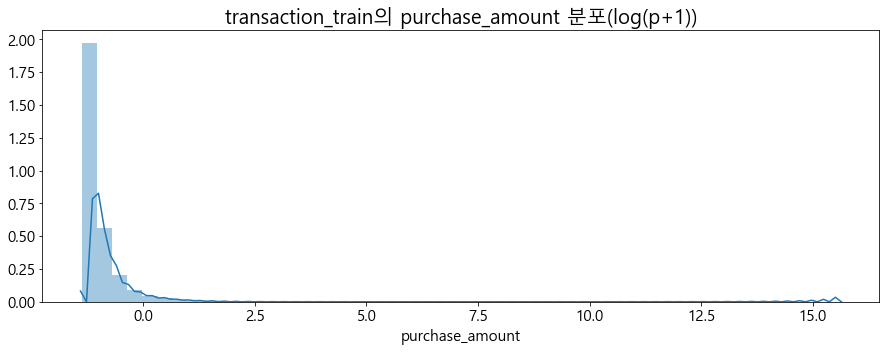

In [60]:
plt.figure(figsize=(15,5))
plt.title("transaction_train의 purchase_amount 분포(log(p+1))",size=20)
sns.distplot(np.log1p(train_df.purchase_amount))

In [61]:
train_df.loc[train_df.purchase_amount<10]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
0,0,C_ID_5037ff576e,322,0,1,B,278,M_ID_b61c7d1be0,10,-0.595260,...,3,11,37,2017-01,5,1,1,-2.352713,8,1
1,1,C_ID_5037ff576e,138,0,1,B,307,M_ID_fe69229f24,9,1.189469,...,1,15,19,2017-01,5,1,1,-2.352713,7,1
2,1,C_ID_5037ff576e,138,0,1,B,705,M_ID_efc106141c,4,-0.640069,...,1,15,33,2017-01,5,1,1,-2.352713,1,1
3,1,C_ID_5037ff576e,226,0,1,B,307,M_ID_708022307c,9,-0.652256,...,1,16,19,2017-01,5,1,1,-2.352713,7,1
4,1,C_ID_5037ff576e,330,0,1,B,705,M_ID_393b4b8cec,4,-0.674210,...,3,17,33,2017-01,5,1,1,-2.352713,1,1
5,1,C_ID_5037ff576e,138,0,1,B,307,M_ID_fe69229f24,4,-0.671775,...,1,15,19,2017-01,5,1,1,-2.352713,1,1
6,1,C_ID_5037ff576e,278,0,1,B,705,M_ID_d70b0fd11b,7,-0.627477,...,5,5,33,2017-01,5,1,1,-2.352713,5,1
7,0,C_ID_5037ff576e,221,0,1,B,307,M_ID_16cf5cd707,12,-0.658296,...,2,24,19,2017-01,5,1,1,-2.352713,10,1
8,1,C_ID_5037ff576e,19,0,1,B,278,M_ID_6a5ddaaba7,5,-0.696569,...,1,9,37,2017-01,5,1,1,-2.352713,3,1
9,1,C_ID_5037ff576e,331,0,1,B,332,M_ID_46ab73a225,11,-0.521510,...,1,16,2,2017-01,5,1,1,-2.352713,9,1


In [62]:
#target -30 이하인 열 빼려고 했으나 빼면 unique id의 개수가 달라져서 살리기로함
# https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
# https://www.kaggle.com/raddar/target-true-meaning-revealed 여기에 -30이하 타겟의 의미가 있음
# 미래의 소비 / 과거의 소비 비율
len(np.unique(train_df.card_id[train_df.target>-30]))

199710

In [63]:
### categorical 은 가장 많이 나온 것을 이용
### numerical 은 평균 or 중앙값이용 

In [64]:
train_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,month_diff,cnt
0,0,C_ID_5037ff576e,322,0,1,B,278,M_ID_b61c7d1be0,10,-0.595260,...,3,11,37,2017-01,5,1,1,-2.352713,8,1
1,1,C_ID_5037ff576e,138,0,1,B,307,M_ID_fe69229f24,9,1.189469,...,1,15,19,2017-01,5,1,1,-2.352713,7,1
2,1,C_ID_5037ff576e,138,0,1,B,705,M_ID_efc106141c,4,-0.640069,...,1,15,33,2017-01,5,1,1,-2.352713,1,1
3,1,C_ID_5037ff576e,226,0,1,B,307,M_ID_708022307c,9,-0.652256,...,1,16,19,2017-01,5,1,1,-2.352713,7,1
4,1,C_ID_5037ff576e,330,0,1,B,705,M_ID_393b4b8cec,4,-0.674210,...,3,17,33,2017-01,5,1,1,-2.352713,1,1


In [ ]:
purchase_count_by_month=pd.DataFrame(
    {'month' : train_df.purchase_date_dt.value_counts().index,
     'count' : train_df.purchase_date_dt.value_counts().values}).sort_values(by='month').reset_index(drop=True)

In [ ]:
purchase_quantinty

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(x='month',y='count',data=purchase_count_by_month)

# y columns
* target(train.csv)

In [138]:
# target -30 이하인 열 빼려고 했으나 빼면 unique id의 개수가 달라져서 살리기로함
# https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
# https://www.kaggle.com/raddar/target-true-meaning-revealed 여기에 -30이하 타겟의 의미가 있음
# 미래의 소비 / 과거의 소비 비율

In [113]:
print('-30 이하 target 제거 전 unique_id 개수 : {} '.format(len(np.unique(train_df.card_id))))
print('-30 이하 target 제거 후 unique_id 개수 : {} '.format(len(np.unique(train_df.card_id[train_df.target>-30]))))
print('{} 개의 데이터 손실 발생 '.format(len(np.unique(train_df.card_id))-len(np.unique(train_df.card_id[train_df.target>-30]))))

-30 이하 target 제거 전 unique_id 개수 : 201917 
-30 이하 target 제거 후 unique_id 개수 : 199710 
2207 개의 데이터 손실 발생 


### 새로 만든 month_diff 에서 
### 모순 데이터(first_active_moth 보다 purchase_date 가 시간상 앞서는 데이터) 빼고 target 확인

In [133]:
check_drop_df=train_df.loc[train_df.month_diff>=0]
check_drop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19237031 entries, 0 to 19249693
Data columns (total 21 columns):
authorized_flag         int64
card_id                 object
city_id                 int16
category_1              int64
installments            int16
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float32
purchase_date           object
category_2              uint16
state_id                int64
subsector_id            int64
first_active_month      object
feature_1               uint8
feature_2               uint8
feature_3               uint8
target                  float32
month_diff              int32
cnt                     int64
dtypes: float32(2), int16(2), int32(1), int64(7), object(5), uint16(1), uint8(3)
memory usage: 2.2+ GB


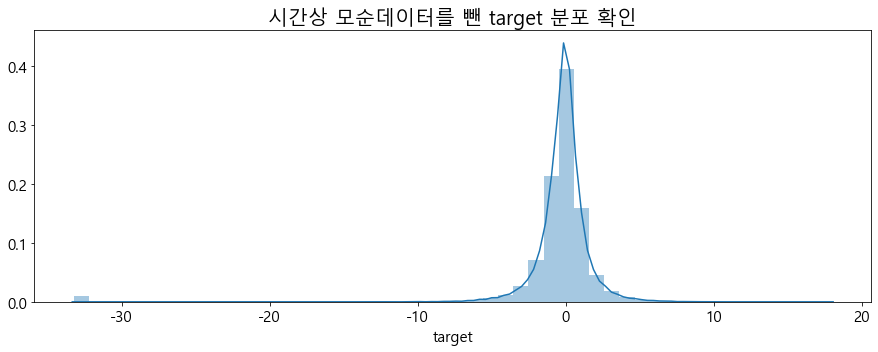

In [136]:
plt.figure(figsize=(15,5))
plt.title('시간상 모순데이터를 뺀 target 분포 확인',size=20)
sns.distplot(check_drop_df.target)

### 각 카테고리에서 가장 많이 나온 값을 card_id에 1:1 매칭 시키는 코드 만드려고 하였으나,
### 한 card_id에 대한 여러가지를 반영하지 못하는 한계가 있음
### 그래서 각 card_id와 특정 column에 대해 발생한 개수의 값을 이용하기로 함
### ex) card_id="M~~~", city_id.nqnique()가 7 이면 값은 7로 설정

In [65]:
columns=['authorized_flag', 'city_id', 'category_1','category_2', 'category_3',
         'installments','merchant_category_id', 'month_lag', 'purchase_amount', 
         'purchase_date', 'state_id', 'subsector_id', 'first_active_month',
         'month_diff', 'cnt']

# base data 생성 기본 로직 변경
## 1. 이산형 데이터 : 각 ID에 존재하는 unique값의 개수
## 2. 연속형 데이터 : 합과 평균 둘다 

In [85]:
## 이산형 데이터 card_id별 unique 값 뽑기 test
train_df.loc[:5000,['card_id','category_3']].groupby(['card_id']).nunique('category_3')

,card_id,category_3
card_id,,
C_ID_0d6b8c2d0f,1,3
C_ID_0e171c1b48,1,2
C_ID_12b7811978,1,1
C_ID_198914cf94,1,2
C_ID_21117571cf,1,1
C_ID_3917d75318,1,2
C_ID_3da75e85ea,1,2
C_ID_3fff3df454,1,2
C_ID_4bed29d75c,1,2


In [86]:
test_index=train_df.loc[:5000,['card_id','category_3']].groupby(['card_id']).nunique('category_3').index
test_index

Index(['C_ID_0d6b8c2d0f', 'C_ID_0e171c1b48', 'C_ID_12b7811978',
       'C_ID_198914cf94', 'C_ID_21117571cf', 'C_ID_3917d75318',
       'C_ID_3da75e85ea', 'C_ID_3fff3df454', 'C_ID_4bed29d75c',
       'C_ID_5037ff576e', 'C_ID_55aa6d6d5e', 'C_ID_93d201f55f',
       'C_ID_b271e7ab60', 'C_ID_b45d4d37b1', 'C_ID_d244d8976d',
       'C_ID_d3ec4a9f31', 'C_ID_e5f5fcf6e7', 'C_ID_fc8e41b9cf'],
      dtype='object', name='card_id')

In [87]:
test_values=train_df.loc[:5000,['card_id','category_3']].groupby(['card_id']).nunique('category_3').values[:,-1]
test_values

array([3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3], dtype=int64)

In [88]:
pd.DataFrame({'card_id':train_df.loc[:5000,['card_id','category_3']].groupby(['card_id']).nunique('category_3').index,
              'category_3_nunique':train_df.loc[:5000,['card_id','category_3']].groupby(['card_id']).nunique('category_3').values[:,-1]})

,card_id,category_3_nunique
0,C_ID_0d6b8c2d0f,3
1,C_ID_0e171c1b48,2
2,C_ID_12b7811978,1
3,C_ID_198914cf94,2
4,C_ID_21117571cf,1
5,C_ID_3917d75318,2
6,C_ID_3da75e85ea,2
7,C_ID_3fff3df454,2
8,C_ID_4bed29d75c,2
9,C_ID_5037ff576e,2


In [66]:
train_new=pd.DataFrame({'card_id':np.unique(train_df.card_id)})
train_new

,card_id
0,C_ID_00007093c1
1,C_ID_0001506ef0
2,C_ID_000183fdda
3,C_ID_00027503e2
4,C_ID_0002c7c2c1
5,C_ID_0003be3c83
6,C_ID_00042d509c
7,C_ID_0004888ddd
8,C_ID_0004b68c49
9,C_ID_0004c2a5ab


In [ ]:
for i in 

In [8]:
category=['authorized_flag','city_id','category_1','category_2','category_3','merchant_category_id','state_id','subsector_id',]
colname=[]
value=[]
for category_columns in category:
    value.append(train_df['{}'.format(category_columns)].value_counts().index[0])
    colname.append(category_columns)
temp=pd.DataFrame({'column_name':colname,'value':value})
temp

,column_name,value
0,authorized_flag,Y
1,city_id,69
2,category_1,N
3,category_2,1
4,category_3,A
5,merchant_category_id,705
6,state_id,9
7,subsector_id,33


# 4. EDA
## 1. train/test

In [ ]:
train_df=pd.read_csv("D:/kaggle/ELO/data/train_df.csv",encoding='utf-8')
test_df=pd.read_csv("D:/kaggle/ELO/data/test_df.csv",encoding='utf-8')

In [17]:
train.tail(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
201914,2017-08,C_ID_7666735b3d,4,3,0,0.093494
201915,2016-07,C_ID_73f5a0efd0,3,2,1,-4.676589
201916,2017-07,C_ID_92c9984c58,3,1,1,-1.859413


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [19]:
test.tail(3)

,first_active_month,card_id,feature_1,feature_2,feature_3
123620,2016-09,C_ID_21d56d950c,5,1,1
123621,2017-06,C_ID_6c46fc5a9d,2,1,0
123622,2016-10,C_ID_87e7979a5f,5,1,1


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


### 전체 데이터 행/열 확인

In [22]:
print("------------전체 데이터 행/열 개수 확인------------")
print("train         : {} ".format(train.shape))
print("test          : {} ".format(test.shape))
print("trans_hist    : {} ".format(trans_hist.shape))
print("trans_new     : {} ".format(trans_new.shape))
print("-----------------------------------------")

------------전체 데이터 행/열 개수 확인------------
train         : (201917, 6) 
test          : (123623, 5) 
trans_hist    : (29112361, 14) 
trans_new     : (1963031, 14) 
-----------------------------------------


### card_id 포함 관계 확인

In [23]:
############################ Set(집합) 다루기 ############################ 
##  1. 합집합 (|)
##  2. 차집합 (-)
##  3. 교집합 (&)
##########################################################################

In [24]:
### unique card_id
train_id=set(np.unique(train.card_id))
test_id=set(np.unique(test.card_id))
trans_hist_id=set(np.unique(trans_hist.card_id))
trans_new_id=set(np.unique(trans_new.card_id))
traintest_id=train_id|test_id 
print("------------ unique card_id 개수 확인------------")
print("train_id           : {} 개".format(len(train_id)))
print("test_id            : {} 개".format(len(test_id)))
print("train+test         : {} 개".format(len(traintest_id)))
print()
print("trans_hist_id      : {} 개".format(len(trans_hist_id)))
print("trans_new_id       : {} 개".format(len(trans_new_id)))
print("-------------------------------------------------")

------------ unique card_id 개수 확인------------
train_id           : 201917 개
test_id            : 123623 개
train+test         : 325540 개

trans_hist_id   : 325540 개
trans_new_id       : 290001 개
-------------------------------------------------


In [25]:
### intersect card_id
print("------------ card_id 포함 관계 확인------------")
print("# 중복(포함)없음 - 배반관계")
print("train         ∩   test          : {} 개".format(len(train_id&test_id)))              # 중복 없음
print()
print("### train+test  ⊂   trans_hist ###")
print("train         ∩   trans_hist : {} 개".format(len(train_id&trans_hist_id)))     # train      ⊂ trans_hist 
print("test          ∩   trans_hist : {} 개".format(len(test_id&trans_hist_id)))      # test       ⊂ trans_hist 
print("train+test    ∩   trans_hist : {} 개".format(len(traintest_id&trans_hist_id))) # train+test ⊂trans_hist 
print() 

print("### train+test  ⊂   trans_new ###")
print("train         ∩   trans_new     : {} 개".format(len(train_id&trans_new_id)))         # train      ⊂ trans_new 
print("test          ∩   trans_new     : {} 개".format(len(test_id&trans_new_id)))          # test       ⊂ trans_new 
print("train+test    ∩   trans_new     : {} 개".format(len(traintest_id&trans_new_id)))     # train+test ⊂ trans_new 
print()

print("### trans_new   ⊂ trans_hist ###")
print("trans_hist ∩ trans_new       : {} 개".format(len(trans_hist_id&trans_new_id))) # trans_new  ⊂ trans_hist
print("------------------------------------------------")

------------ card_id 포함 관계 확인------------
# 중복(포함)없음 - 배반관계
train         ∩   test          : 0 개

### train+test  ⊂   trans_hist ###
train         ∩   trans_hist : 201917 개
test          ∩   trans_hist : 123623 개
train+test    ∩   trans_hist : 325540 개

### train+test  ⊂   trans_new ###
train         ∩   trans_new     : 179986 개
test          ∩   trans_new     : 110015 개
train+test    ∩   trans_new     : 290001 개

### trans_new   ⊂ trans_hist ###
trans_hist ∩ trans_new       : 290001 개
------------------------------------------------


In [19]:
### catgory_2 /  feature_1,2,3 은 categorical이므로 int형으로 전환
# category_2의 경우, na 존재하므로 
all_trans['category_2']=all_trans['category_2'].astype(int)
all_trans['feature_1']=all_trans['feature_1'].astype(int)
all_trans['feature_2']=all_trans['feature_1'].astype(int)
all_trans['feature_3']=all_trans['feature_1'].astype(int)
all_trans.tail(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
31075389,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1,9,37,2017-09,4,4,4,0.360656
31075390,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3,7,16,2016-07,2,2,2,-1.680951
31075391,Y,C_ID_a935410f8e,19,N,0,A,278,M_ID_d855771cd9,2,-0.739395,2018-04-11 07:59:46,1,9,37,2017-04,2,2,2,4.568632


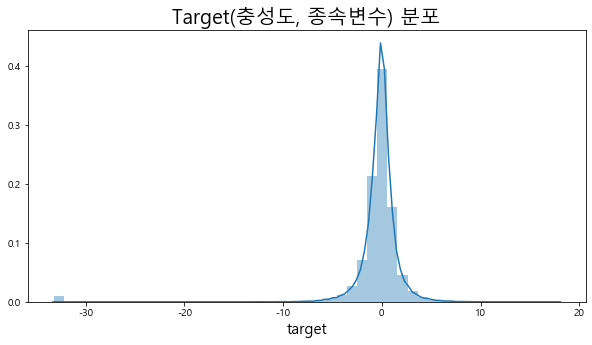

In [20]:
### target 분포 확인 (all_trans / train 쪽만)
plt.figure(figsize=(10,5))
plt.title("Target(충성도, 종속변수) 분포",size=20)
sns.distplot(all_trans.target)

In [21]:
print('-30 이하 target 값은 {} 개.'.format(len(train.loc[train.target < -30])))

-30 이하 target 값은 2207 개.


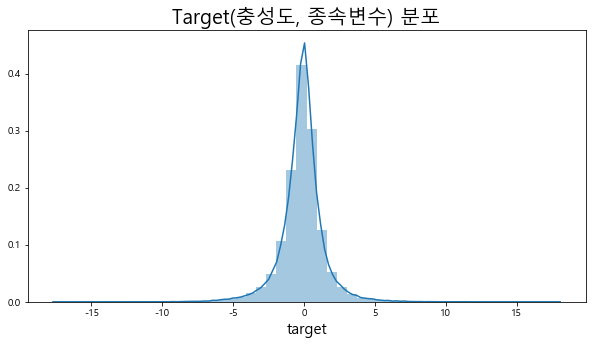

In [22]:
# 2207개의 -30근방 target 값 빼고 보기
all_trans=all_trans.loc[all_trans.target>-30]
plt.figure(figsize=(10,5))
plt.title("Target(충성도, 종속변수) 분포",size=20)
sns.distplot(all_trans.target)

In [23]:
np.mean(all_trans.target)

-0.1331496693080424

### 각 변수와 target 간의 관계확인
#### 1.categorical : authorized_flag / city_id / category_1,2,3 / state_id / subsector_id /  / feature_1,2,3
#### 2.numerical : installments / month_lag / purchase_amount 
#### 3.datetime : purchase_date / first_active_month / first_active_month

<br>

* categorical 변수: 각 카테고리에 대한 target 평균값 확인(countplot)
* numerical 변수: 각 변수에 따른 분포 확인(scatterplot)
* datetime 관련 변수는 년/월/일등으로 분해해서 보기

## 대부분의 categorical 변수들의 충성도가 음수인 이유 
* target이 -30인 2207개의 값들이 평균에 영향을 미쳐 변수 대부분의 충성도가 -값이 됨, 이것에 대한 전처리 고민 필요하다

### 1. target_mean ~ authorized_flag

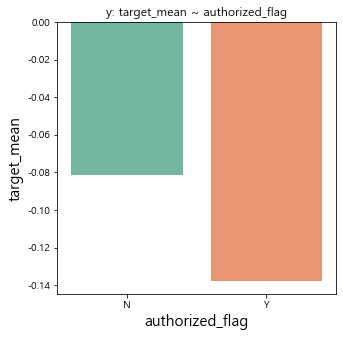

In [24]:
# 평균값 자체는 y,n 둘다 충성도 낮음
# 그나마 y가 더 높음
plt.figure(figsize=(5,5))

target_by_authorized_flag=pd.DataFrame({"authorized_flag":all_trans.groupby('authorized_flag').target.mean().index,
                                        "target_mean":all_trans.groupby('authorized_flag').target.mean().values})
plt.title('y: target_mean ~ authorized_flag',size=12)
sns.barplot(data=target_by_authorized_flag,x='authorized_flag',y=('target_mean'),palette='Set2')

### 2. target_mean ~ city_id

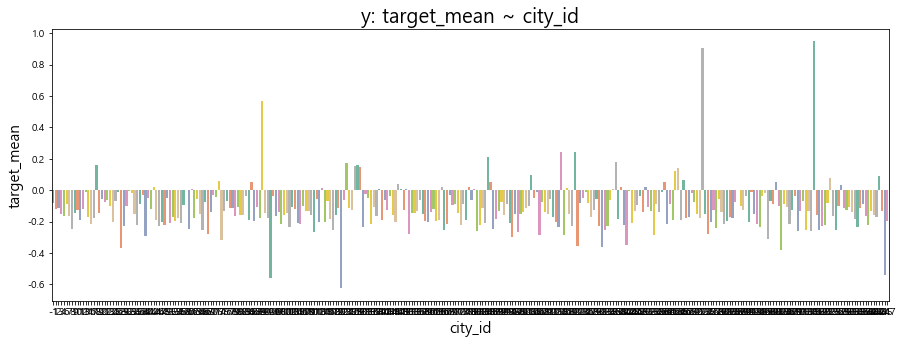

In [25]:
# 몇몇 city를 제외하고 평균 값이 다 음수
plt.figure(figsize=(15,5))
target_by_city_id=pd.DataFrame({"city_id":all_trans.groupby('city_id').target.mean().index,
                                        "target_mean":all_trans.groupby('city_id').target.mean().values})
plt.title('y: target_mean ~ city_id')
sns.barplot(data=target_by_city_id,x='city_id',y=('target_mean'),palette='Set2')

In [26]:
all_trans.groupby('city_id').target.mean().sort_values(ascending=False)[0:15]

city_id
316    0.949453
273    0.904335
89     0.571904
221    0.246146
215    0.240641
185    0.208876
237    0.178668
124    0.175157
18     0.161203
129    0.160883
128    0.155872
130    0.145500
264    0.143821
263    0.123050
204    0.094068
Name: target, dtype: float64

### 3. target_mean ~ category_1,2,3

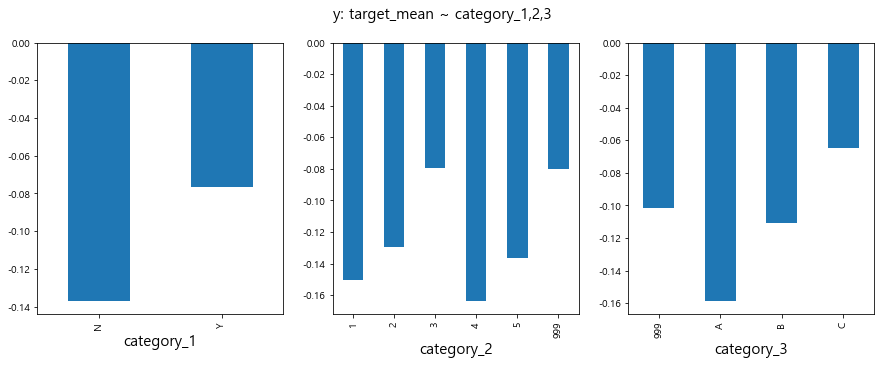

In [27]:
# 모두 충성도 낮음;;;;;
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('y: target_mean ~ category_1,2,3',size=15)
all_trans.groupby(['category_1']).target.mean().plot(kind='bar',ax=ax[0])
all_trans.groupby(['category_2']).target.mean().plot(kind='bar',ax=ax[1])
all_trans.groupby(['category_3']).target.mean().plot(kind='bar',ax=ax[2])

### 4. target_mean ~ state_id

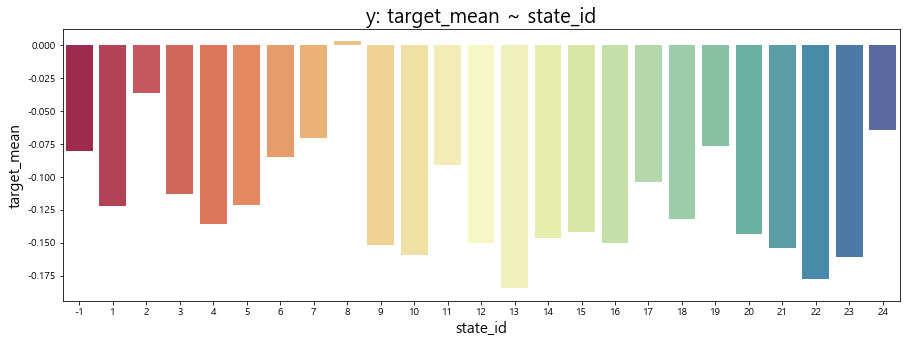

In [28]:
# 모두 충성도 낮음;;;;;
plt.figure(figsize=(15,5))
target_by_state_id=pd.DataFrame({"state_id":all_trans.groupby('state_id').target.mean().index,
                                 "target_mean":all_trans.groupby('state_id').target.mean().values})
plt.title('y: target_mean ~ state_id')
sns.barplot(data=target_by_state_id,x='state_id',y=('target_mean'),palette='Spectral')

### 5. target_mean ~ subsector_id

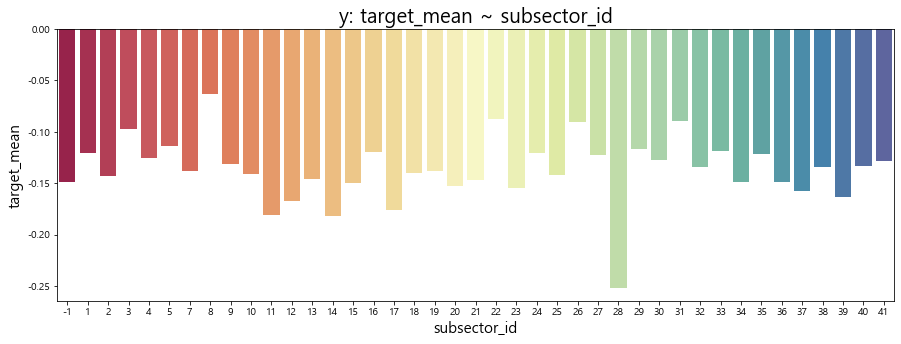

In [29]:
# 모두 충성도 낮음;;;;;
plt.figure(figsize=(15,5))
target_by_subsector_id=pd.DataFrame({"subsector_id":all_trans.groupby('subsector_id').target.mean().index,
                                     "target_mean":all_trans.groupby('subsector_id').target.mean().values})
plt.title('y: target_mean ~ subsector_id')
sns.barplot(data=target_by_subsector_id,x='subsector_id',y=('target_mean'),palette='Spectral')

### 6. target_mean ~ feature_1,2,3

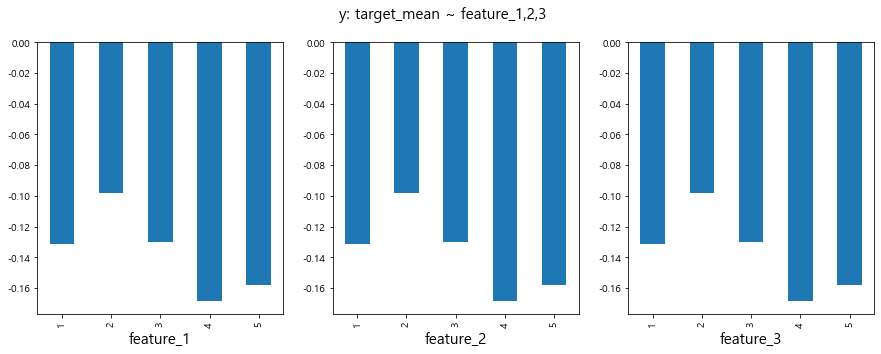

In [30]:
# 모두 충성도 낮음;;;;;
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('y: target_mean ~ feature_1,2,3',size=15)
all_trans.groupby(['feature_1']).target.mean().plot(kind='bar',ax=ax[0])
all_trans.groupby(['feature_2']).target.mean().plot(kind='bar',ax=ax[1])
all_trans.groupby(['feature_3']).target.mean().plot(kind='bar',ax=ax[2])

### 7. target ~ installments

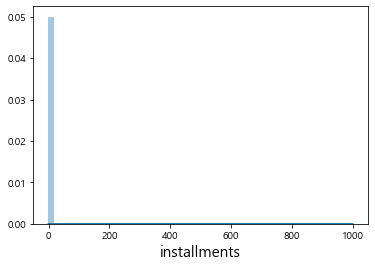

In [31]:
# 이상치 999 때문에 기본 분포 잘 안보임
sns.distplot(all_trans.installments)

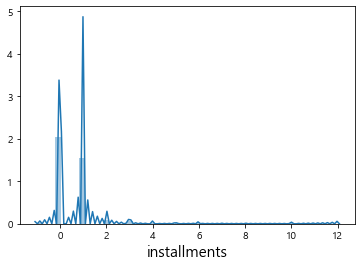

In [32]:
### 12이하까지만 처리
all_trans_install_fix=all_trans.loc[all_trans.installments<13]
sns.distplot(all_trans_install_fix.installments)

Text(0.5, 1.0, 'y: target_mean ~ installments_mean')

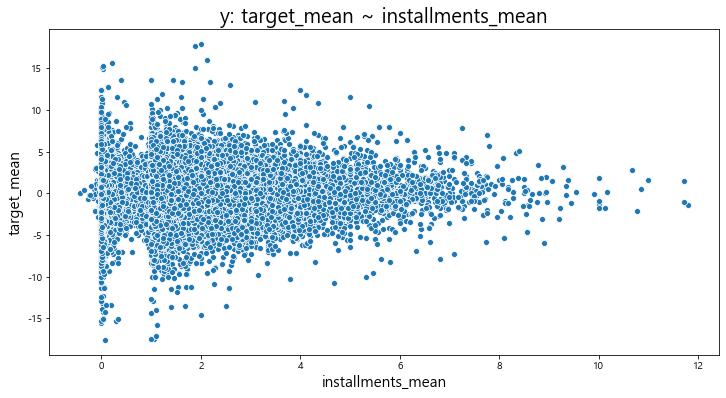

In [33]:
### 한 card_id에 여러 installment가 걸리므로 평균으로 재처리
# installments 가 커질수록.... target이 0에 수렴? 의미 없어보임...
plt.figure(figsize=(12,6))
temp_installments=all_trans_install_fix.groupby('card_id').aggregate({'installments':'mean','target':'mean'})
temp_installments.columns=['installments_mean','target_mean']
sns.scatterplot(data=temp_installments,
                x='installments_mean',y='target_mean')
plt.title('y: target_mean ~ installments_mean')

### 8. target ~ month_lag

Text(0.5, 1.0, 'y: target_mean ~ month_lag_mean')

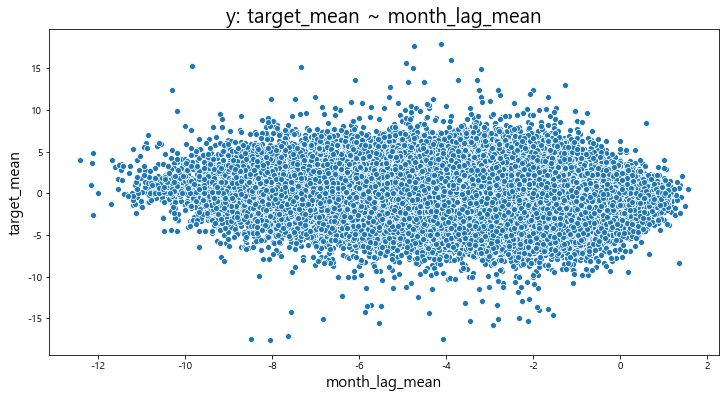

In [34]:
### 한 card_id에 여러 month_lag이 걸리므로 평균으로 재처리
# month_lag 가 커질수록.... target이 0에 수렴? 의미 없어보임...
plt.figure(figsize=(12,6))
temp_month_lag=all_trans_install_fix.groupby('card_id').aggregate({'month_lag':'mean','target':'mean'})
temp_month_lag.columns=['month_lag_mean','target_mean']
sns.scatterplot(data=temp_month_lag,
                x='month_lag_mean',y='target_mean')
plt.title('y: target_mean ~ month_lag_mean')

In [ ]:
############# 코드 에러 일시중단 ###################

### 9. target ~ purchase_amount

In [35]:
print(min(all_trans.purchase_amount),max(all_trans.purchase_amount))

-0.7469078 6010603.9717525


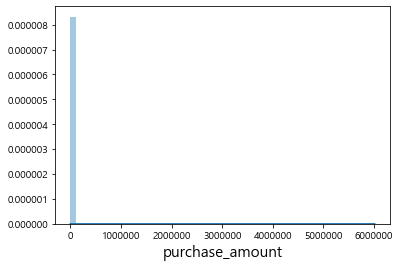

In [36]:
## 10만 이하에 대다수 분포하므로 10만 이하만 처리
sns.distplot(all_trans.purchase_amount)

In [49]:
print(sum(all_trans.purchase_amount<100000))
print(len(all_trans.purchase_amount))
print(np.mean(all_trans.purchase_amount))

19062118
19062128
0.11622966990133518


In [51]:
sns.distplot(test.purchase_amount)

AttributeError: 'DataFrame' object has no attribute 'purchase_amount'

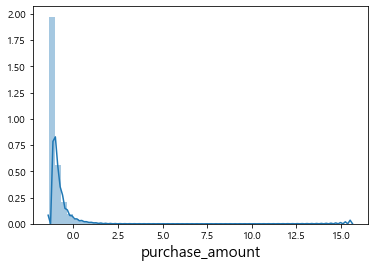

In [47]:
log_purchase_amount=np.log1p(all_trans.purchase_amount)
sns.distplot(log_purchase_amount)

In [43]:
all_trans.purchase_amount[all_trans.purchase_amount>100000]

10018048    1.202151e+05
12097071    1.352415e+05
15265708    1.051865e+05
19397260    1.199196e+05
19745877    1.652987e+05
20537106    1.472606e+05
22562437    1.347588e+05
24641886    1.277315e+05
28417440    1.382450e+05
29050360    6.010604e+06
Name: purchase_amount, dtype: float64

In [ ]:
### purchase_amount의 경우 
### 1.총 구매량에 대한 합 기준 
### 2.다른 통계량(평균,중앙값 등) 의 추가 고민 가능... 일단 sum이랑 mean만
### -- target 은 그대로 mean

## 1. sum 기준 
all_trans_puchase_amount_fix_sum=all_trans.loc[all_trans.purchase_amount<100000]
plt.figure(figsize=(12,6))
temp_puchase_amount_sum=all_trans_puchase_amount_fix_sum.groupby('card_id').aggregate({'purchase_amount':'sum','target':'mean'})
temp_puchase_amount_sum.columns=['purchase_amount_sum','target_mean']
sns.scatterplot(data=temp_puchase_amount_sum,
                x='purchase_amount_sum',y='target_mean')
plt.title('y: purchase_amount_sum ~ month_lag_mean')

In [ ]:
## 2. mean 기준 
all_trans_puchase_amount_fix_sum=all_trans.loc[all_trans.purchase_amount<100000]
plt.figure(figsize=(12,6))
temp_puchase_amount_sum=all_trans_puchase_amount_fix_sum.groupby('card_id').aggregate({'purchase_amount':'sum','target':'mean'})
temp_puchase_amount_sum.columns=['purchase_amount_sum','target_mean']
sns.scatterplot(data=temp_puchase_amount_sum,
                x='purchase_amount_sum',y='target_mean')
plt.title('y: purchase_amount_sum ~ month_lag_mean')

## historycal_trasaction.csv 

### first_active_month 

[Text(0, 0, '2011-11'),
 Text(0, 0, '2011-12'),
 Text(0, 0, '2012-02'),
 Text(0, 0, '2012-03'),
 Text(0, 0, '2012-04'),
 Text(0, 0, '2012-05'),
 Text(0, 0, '2012-06'),
 Text(0, 0, '2012-07'),
 Text(0, 0, '2012-08'),
 Text(0, 0, '2012-09'),
 Text(0, 0, '2012-10'),
 Text(0, 0, '2012-11'),
 Text(0, 0, '2012-12'),
 Text(0, 0, '2013-01'),
 Text(0, 0, '2013-02'),
 Text(0, 0, '2013-03'),
 Text(0, 0, '2013-04'),
 Text(0, 0, '2013-05'),
 Text(0, 0, '2013-06'),
 Text(0, 0, '2013-07'),
 Text(0, 0, '2013-08'),
 Text(0, 0, '2013-09'),
 Text(0, 0, '2013-10'),
 Text(0, 0, '2013-11'),
 Text(0, 0, '2013-12'),
 Text(0, 0, '2014-01'),
 Text(0, 0, '2014-02'),
 Text(0, 0, '2014-03'),
 Text(0, 0, '2014-04'),
 Text(0, 0, '2014-05'),
 Text(0, 0, '2014-06'),
 Text(0, 0, '2014-07'),
 Text(0, 0, '2014-08'),
 Text(0, 0, '2014-09'),
 Text(0, 0, '2014-10'),
 Text(0, 0, '2014-11'),
 Text(0, 0, '2014-12'),
 Text(0, 0, '2015-01'),
 Text(0, 0, '2015-02'),
 Text(0, 0, '2015-03'),
 Text(0, 0, '2015-04'),
 Text(0, 0, '201

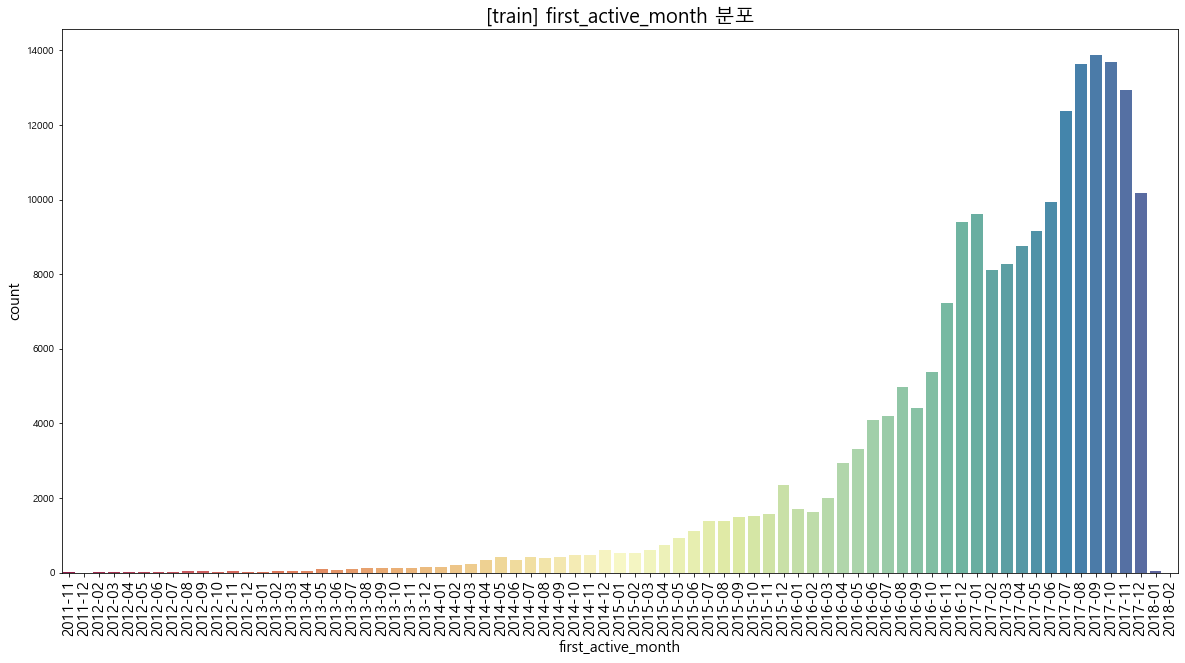

In [134]:
### first_active_month 
plt.figure(figsize=(20,10))
plt.title("[train] first_active_month 분포",size=20)
first_active_month=sns.countplot(x=train.first_active_month,palette='Spectral',
            order = sorted(train.first_active_month.value_counts().index))
first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

[Text(0, 0, '2011-11'),
 Text(0, 0, '2011-12'),
 Text(0, 0, '2012-01'),
 Text(0, 0, '2012-02'),
 Text(0, 0, '2012-03'),
 Text(0, 0, '2012-04'),
 Text(0, 0, '2012-05'),
 Text(0, 0, '2012-06'),
 Text(0, 0, '2012-07'),
 Text(0, 0, '2012-08'),
 Text(0, 0, '2012-09'),
 Text(0, 0, '2012-10'),
 Text(0, 0, '2012-11'),
 Text(0, 0, '2012-12'),
 Text(0, 0, '2013-01'),
 Text(0, 0, '2013-02'),
 Text(0, 0, '2013-03'),
 Text(0, 0, '2013-04'),
 Text(0, 0, '2013-05'),
 Text(0, 0, '2013-06'),
 Text(0, 0, '2013-07'),
 Text(0, 0, '2013-08'),
 Text(0, 0, '2013-09'),
 Text(0, 0, '2013-10'),
 Text(0, 0, '2013-11'),
 Text(0, 0, '2013-12'),
 Text(0, 0, '2014-01'),
 Text(0, 0, '2014-02'),
 Text(0, 0, '2014-03'),
 Text(0, 0, '2014-04'),
 Text(0, 0, '2014-05'),
 Text(0, 0, '2014-06'),
 Text(0, 0, '2014-07'),
 Text(0, 0, '2014-08'),
 Text(0, 0, '2014-09'),
 Text(0, 0, '2014-10'),
 Text(0, 0, '2014-11'),
 Text(0, 0, '2014-12'),
 Text(0, 0, '2015-01'),
 Text(0, 0, '2015-02'),
 Text(0, 0, '2015-03'),
 Text(0, 0, '201

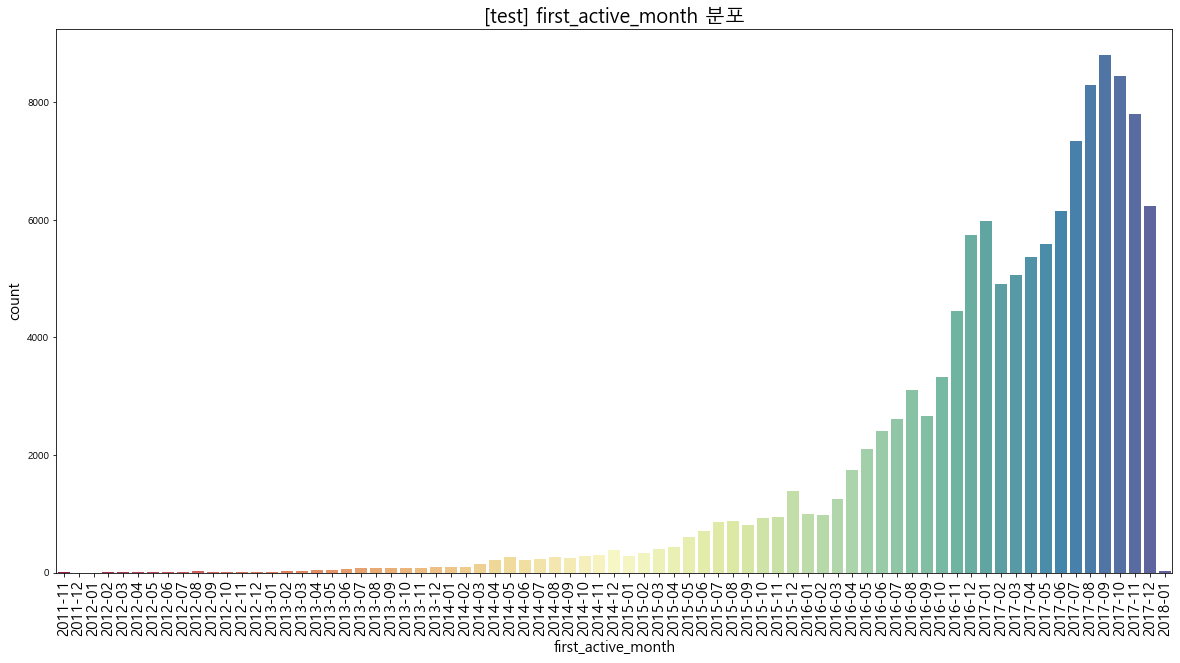

In [17]:
### first_active_month 
plt.figure(figsize=(20,10))
plt.title("[test] first_active_month 분포",size=20)
first_active_month=sns.countplot(x=test.first_active_month,palette='Spectral',
            order = np.sort(test.first_active_month.value_counts().index))
first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

### feature 1/2/3

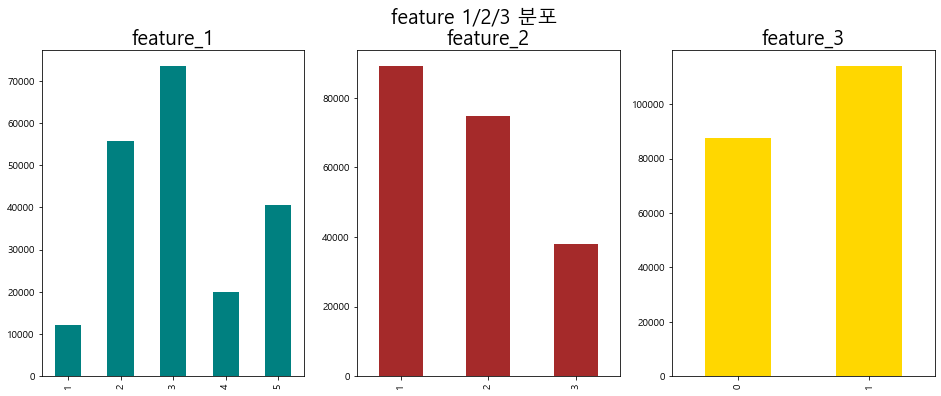

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('feature 1/2/3 분포',size=20);

### target

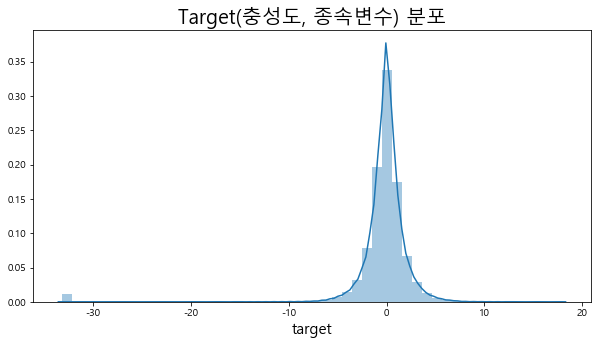

In [19]:
plt.figure(figsize=(10,5))
plt.title("Target(충성도, 종속변수) 분포",size=20)
sns.distplot(train.target)

In [20]:
print('-30 이하 target 값은 {} 개.'.format(len(train.loc[train.target < -30])))

-30 이하 target 값은 2207 개.


## 2. transactions(historical / new)

In [21]:
history_trans.head()
history_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [22]:
colname=[]
na_count=[]

for column in history_trans.columns.values:
    colname.append(column)
    na_count.append(history_trans['{}'.format(column)].isna().sum())
    
                    
col=pd.DataFrame(colname,columns=['열이름'])
count=pd.DataFrame(na_count,columns=['NA개수'])


na_df=pd.concat([col,count],axis=1)
na_df['NA비율(%)']=na_df['NA개수']/len(history_trans.card_id)*100
na_df

,열이름,NA개수,NA비율(%)
0,authorized_flag,0,0.000000
1,card_id,0,0.000000
2,city_id,0,0.000000
3,category_1,0,0.000000
4,installments,0,0.000000
5,category_3,178159,0.611970
6,merchant_category_id,0,0.000000
7,merchant_id,138481,0.475678
8,month_lag,0,0.000000
9,purchase_amount,0,0.000000


In [23]:
print('Purchase date 기간:',min(history_trans.purchase_date),'~',max(history_trans.purchase_date))

Purchase date 기간: 2017-01-01 00:00:08 ~ 2018-02-28 23:59:51


### month_lag

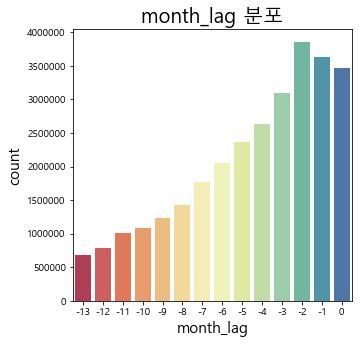

In [24]:
### first_active_month 
plt.figure(figsize=(5,5))
plt.title("month_lag 분포",size=20)
month_lag=sns.countplot(x=history_trans.month_lag,palette='Spectral')
#first_active_month.set_xticklabels(first_active_month.get_xticklabels(), rotation=90, size=15)

### authorized_flag

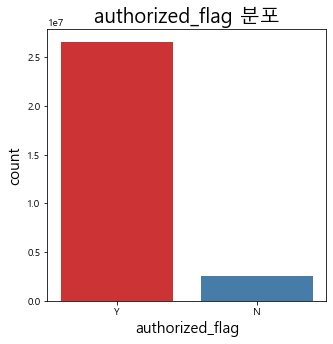

In [25]:
### authorized_flag
plt.figure(figsize=(5,5))
plt.title("authorized_flag 분포",size=20)
authorized_flag=sns.countplot(x=history_trans.authorized_flag,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [26]:
print(len(history_trans.loc[history_trans.authorized_flag=='Y']))
print(len(history_trans.loc[history_trans.authorized_flag!='Y']))

26595452
2516909


### category_3

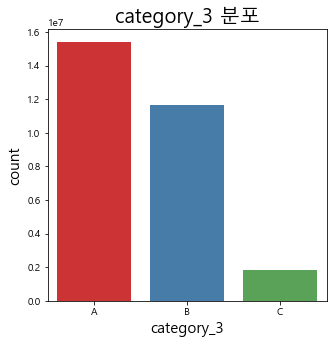

In [27]:
### category_3
plt.figure(figsize=(5,5))
plt.title("category_3 분포",size=20)
category_3=sns.countplot(x=history_trans.category_3,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [28]:
history_trans.category_3.isna().sum()

178159

### installments

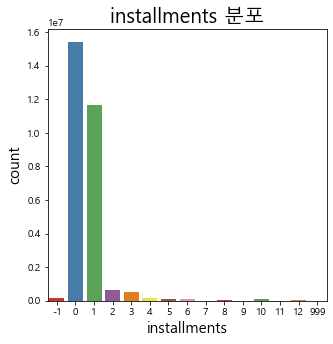

In [29]:
### installments
plt.figure(figsize=(5,5))
plt.title("installments 분포",size=20)
installments=sns.countplot(x=history_trans.installments,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### category_1

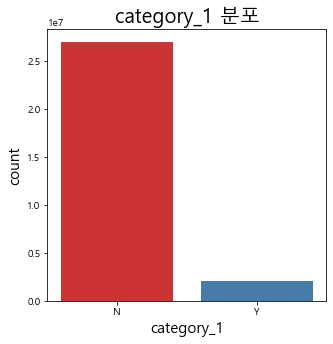

In [30]:
### category_1
plt.figure(figsize=(5,5))
plt.title("category_1 분포",size=20)
category_1=sns.countplot(x=history_trans.category_1,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### merchant_category_id

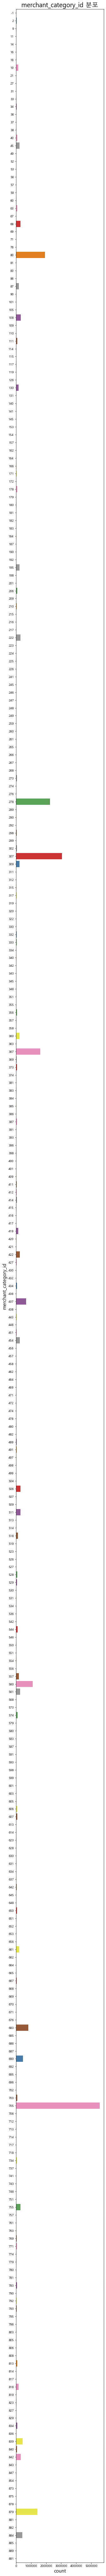

In [31]:
### merchant_category_id
plt.figure(figsize=(5,150))
plt.title("merchant_category_id 분포",size=20)
merchant_category_id=sns.countplot(y=history_trans.merchant_category_id,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [32]:
pd.DataFrame(history_trans.merchant_category_id.value_counts())

,merchant_category_id
705,5554009
307,3057930
278,2254227
80,1929413
367,1608239
...,...
311,1
322,1
882,1
86,1


### subsector_id

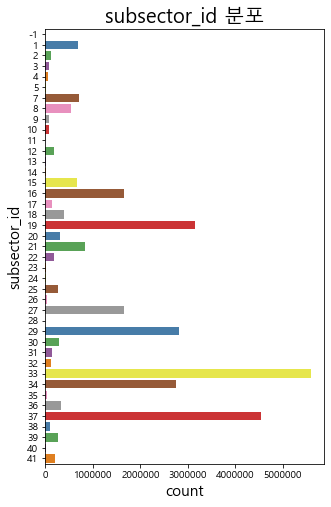

In [33]:
### subsector_id
plt.figure(figsize=(5,8))
plt.title("subsector_id 분포",size=20)
subsector_id=sns.countplot(y=history_trans.subsector_id,palette='Set1')
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

In [34]:
pd.DataFrame(history_trans.subsector_id.value_counts())

,subsector_id
33,5594146
37,4531755
19,3147440
29,2813095
34,2759431
27,1658301
16,1651384
21,837612
7,711977
1,695263


In [35]:
print(len(history_trans.subsector_id.value_counts()))

41


### merchant_id

In [36]:
pd.DataFrame(history_trans.merchant_id.value_counts())

,merchant_id
M_ID_00a6ca8a8a,1115097
M_ID_e5374dabc0,428619
M_ID_9139332ccc,361385
M_ID_50f575c681,183894
M_ID_fc7d7969c3,177040
...,...
M_ID_1678ac856a,1
M_ID_ede7cfeb71,1
M_ID_65c8865e64,1
M_ID_9256828249,1


In [37]:
history_trans.merchant_id.isna().sum()

138481

### purchase_amount

In [38]:
pd.DataFrame(history_trans.purchase_amount.value_counts())

,purchase_amount
-0.671775,687283
-0.716855,600414
-0.701828,510925
-0.731881,417335
-0.596643,389066
...,...
23.065906,1
2.941214,1
19.409655,1
9.262252,1


In [39]:
print('표준화된 구매량 : 최소 {}회 ~ 최대 {}회'.
      format(min(history_trans.purchase_amount),max(history_trans.purchase_amount)))

표준화된 구매량 : 최소 -0.7469078회 ~ 최대 6010603.9717525회


In [40]:
history_trans.purchase_amount.isna().sum()

0

### city_id

In [41]:
pd.DataFrame(history_trans.city_id.value_counts())

,city_id
69,4835441
-1,2478624
19,1151077
158,1113013
17,971714
...,...
319,1645
92,758
273,620
316,149


In [42]:
history_trans.city_id.isna().sum()

0

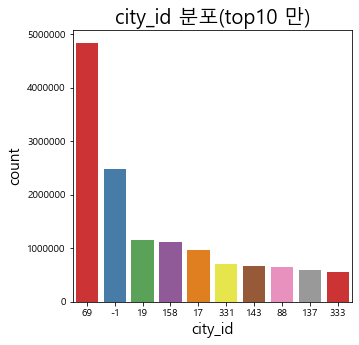

In [43]:
### city_id
plt.figure(figsize=(5,5))
plt.title("city_id 분포(top10 만)",size=20)
city_id=sns.countplot(x=history_trans.city_id,palette='Set1',
                     order=history_trans.city_id.value_counts().index[0:10])
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### state_id

In [44]:
pd.DataFrame(history_trans.state_id.value_counts())

,state_id
9,10568881
-1,2652864
16,2143420
15,2079255
5,1655124
19,1204287
20,1141197
22,971714
21,929594
4,840820


In [45]:
history_trans.city_id.isna().sum()

0

In [46]:
len(history_trans.state_id.value_counts())

25

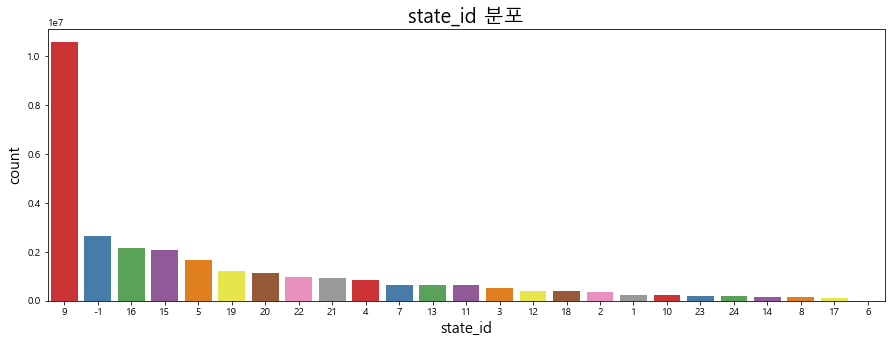

In [47]:
### state_id
plt.figure(figsize=(15,5))
plt.title("state_id 분포",size=20)
state_id=sns.countplot(x=history_trans.state_id,palette='Set1',
                     order=history_trans.state_id.value_counts().index)
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

### category_2

In [48]:
pd.DataFrame(history_trans.category_2.value_counts())

,category_2
1.0,15177199
3.0,3911795
5.0,3725915
4.0,2618053
2.0,1026535


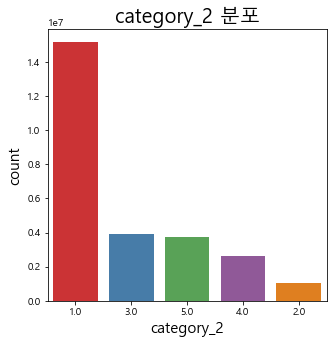

In [49]:
### category_2
plt.figure(figsize=(5,5))
plt.title("category_2 분포",size=20)
category_2=sns.countplot(x=history_trans.category_2,palette='Set1',
                     order=history_trans.category_2.value_counts().index)
#city_id.set_xticklabels(city_id.get_xticklabels(), rotation=90, size=15)

## 3. merchants